# Tompkins Aglorithm : la théorie


Lorsque l’on réalise une analyse de la variabilité de la fréquence cardiaque dans le domaine temporel, il existe plusieurs procédés mathématiques permettant de quantifier l’activité du système nerveux autonome. Bien que chacun d’entres eux génère des indices différents, nous retiendrons qu’ils reposent tous sur le même principe qui consiste à étudier l’évolution des écarts de temps entre chaque intervalle R-R. En d’autres termes, toutes les formules mathématiques d’analyse de la variabilité de la fréquence cardiaque se basent sur une suite numérique qui représente l’écart
de temps, généralement exprimé en millisecondes, de tous les intervalles R-R enregistrés. 

Durant ce projet nous allons ajouter une petite subtilitée à ces calculs qui doit ajouter de la robutesse à notre algorithme. En effet, une détection de pic standard aurait pu être mis en place, on aurait gagné en simplicité et complexité. Cependant pour gagner en robutesse nous avons de décidé de réutiliser et d'implémenter un algorithme donnant un résultat cohérent vraisemblablement pour un signal de type ECG. 

Nous utiliserons celui de Tompkins et al. ont développé un algorithme robuste pour la détection des complexes QRS en simple canal de données ECG.

![ECG Signal](../Images/SinusRhythmLabels.png "Signal ECG")

Ils ont suivi les étapes suivantes:

1 - Filtre Passe bande 5-15Hz composé d’un filtre passe-bas pour supprimer le bruit haute fréquence (comme 50Hz interférence du réseau) et d’un filtre passe-haut pour éliminer les composantes de basse fréquence due à la respiration autour de 1 Hz 

2 - Filtre dérivateur :
Le circuit dérivateur agit comme un filtre passe haut. Étant donné que le complexe QRS possède les fréquences les plus élevées de l’ECG, la dérivée du signal présente à ce niveau des valeurs maximales élevées.

3 - La quadrature: L’objectif de l’élévation en carré est de distinguer entre l’onde R et le reste du signal mis en évidence par la dérivation. Les ondes de petites amplitudes et la partie négative sont supprimées par contre restent les pics de grande amplitude c'est-à-dire les complexes QRS.

4 - Intégration et filtrage à moyenne glissante : L’intégration du signal permet d’obtenir un maximum unique pour chaque complexe. La taille de la fenêtre d’intégration doit être adaptée à la largeur moyenne d’un complexe QRS. Si elle est trop grande, le maximum
est décalé en temps par rapport à la position du R (influence de l’onde T) ; si, au contraire, elle est trop petite, plusieurs pics ont été obtenus pour la même taille de l'onde R choisi ici empiriquement, généralement le double de la largeur moyenne d’un complexe QRS. 

5 - Détection des pics : À l’issue du traitement précédent, le signal disponible possède un maximum absolu pour chaque complexe QRS ; il a également d'autres maxima locaux, de plus faible amplitude. Cette étape consiste donc en une recherche de maxima capable de ne pas prendre en considération les maxima trop faibles qui peuvent correspondre au bruit.

Données : 
Fonctions de transfert des filtre passe-bas et passe-haut

$$
H(z)= \frac{(1-z^{-6})^2}{(1-z^{-1})^2}
$$

$$
H(z)= \frac{(1-32z^{-16}+z^{-32})^2}{(1-z^{-1})^2}
$$

Le filtre à moyenne glissante correspondant à un filtre dont la sortie peut s'écrire : 

$$
y[n]= \frac{1}{N_w}*(x[n-(N_w-1)]+x[n-(N_w-2)] + ... + x[n])
$$
Avec N_w représentant la longueur de la fenêtre du moyennage. 


On obtient ainsi en sortie un signal qui renvoit un ‘1’ lorsqu’un pic est détecté, et vaut 0 s’il n’y a pas.

[1] : Tompkins W & Hamilton P, “Quantitative investigation of QRS detection rules using the MIT/BIH arrhythmia database”, IEEE Trans Biomed Eng 33(12): 1157-1165, 1986.

# Initialisation de nos données et premières observations

In [7]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter, freqz
from math import *
import statistics
print("Setup Complete")

Setup Complete


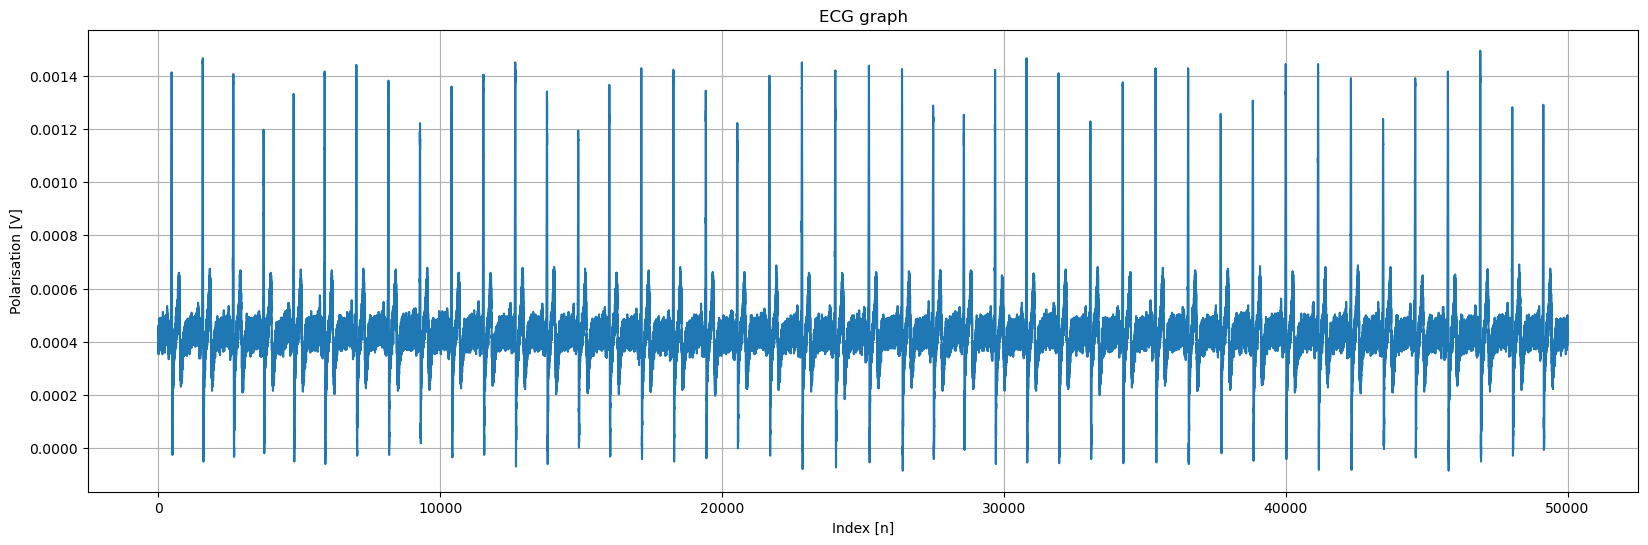

In [8]:
# Path of the file to read
ECG_filepath = "Données/ECGshort.csv"

#Data for ECG plot
xlabel = "Index [n]"
ylabel = "Polarisation [V]"
title = "ECG graph"

def load_DB(filepath):
    # Read the file into a variable data
    data = pd.read_csv(filepath)
    return data

def plot_ECG(data,xlabel,ylabel,title):
  # Set the width and height of the figure
  plt.figure(figsize=(20,6))
  # Line chart showing how ECG values evolved over time 
  plt.plot(data)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()

#Import ECG data
ECG_data = load_DB(ECG_filepath)

# We can use the shape attribute to check how large the resulting DataFrame is:
ECG_data.shape

# Print the first 5 rows of the data
ECG_data.head()

# To access the index i element of the column Data : DataFrama.ColName[i] or DataFrama['ColName'][i]
ECG_data.Data[0]

# Both loc and iloc are row-first, column-second operator
ECG_data.iloc[:, 0]

#Visualisation of our DB
plot_ECG(ECG_data,xlabel,ylabel,title)

# 1. Filtrage passe-bande

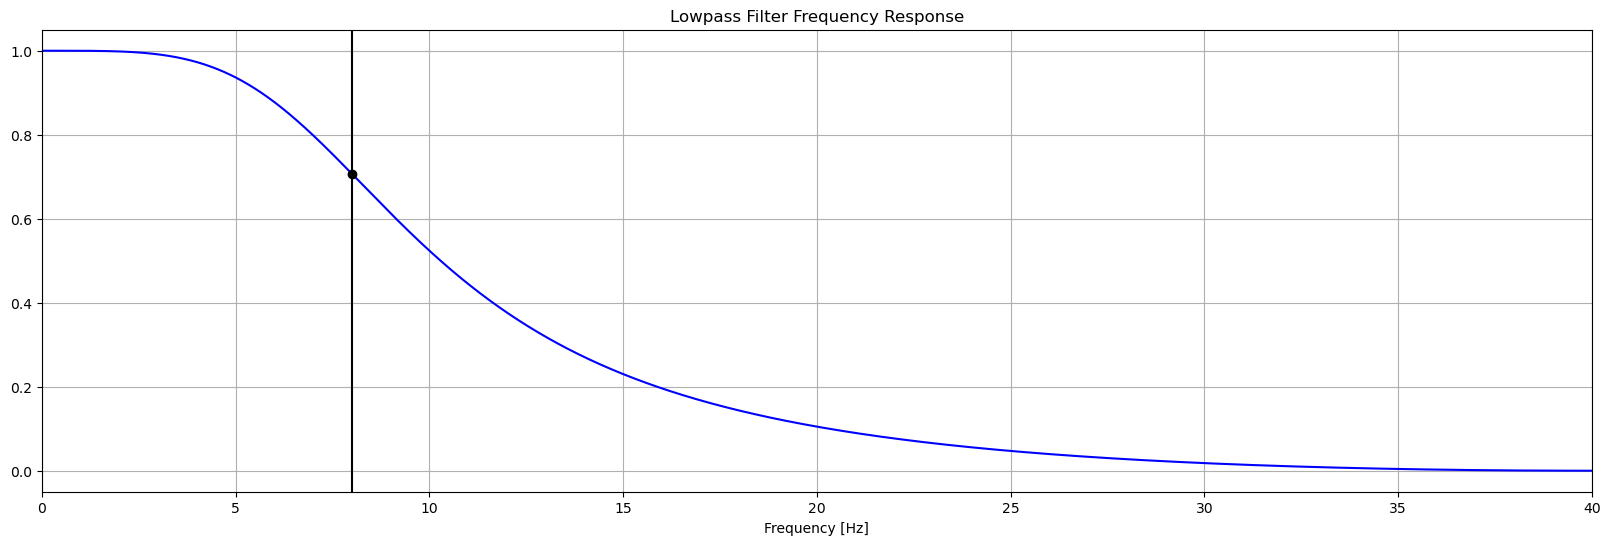

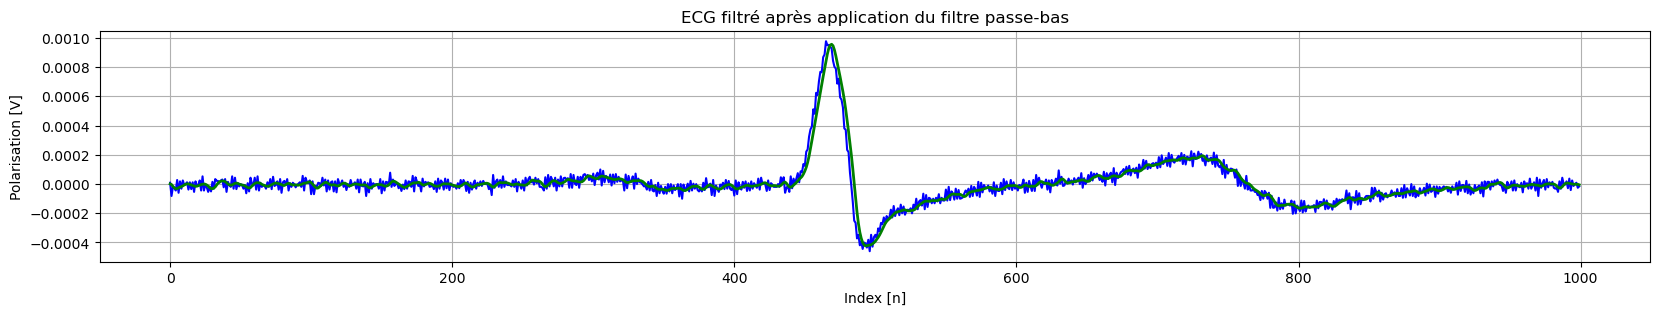

In [9]:
#Initialisation of lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

#Result of the filtering of a signal by a lowpass filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Setting standard filter requirements.
order = 2
fs = 80      
cutoff = 8 

#Creation of our lowpass filter
b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(20,6))
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

#n=ECG_data.size
n=1000
#The new mean of our signal is egal to 0
data = ECG_data.iloc[:n,0] - ECG_data.iloc[:n,0].mean()

# Filtering and plotting our ECG signal
y = butter_lowpass_filter(data, cutoff, fs, order)

# Plotting the the signal before and after being filtered.
plt.figure(figsize=(20,3))
#Old data
plt.plot(data, 'b-', label='data')
#New data filtered
plt.plot(y, 'g-', linewidth=2, label='filtered data')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("ECG filtré après application du filtre passe-bas")
plt.grid()

# Filtrage dérivateur

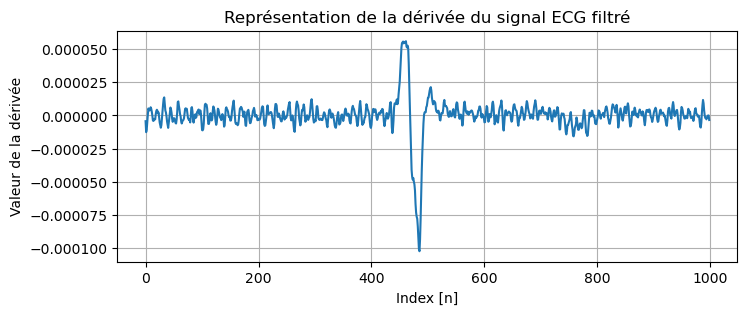

In [10]:
#Calcul de la dérivée du signal
x = np.linspace(1, n,n)

#Calcul du taux d'accroissement
derive = [(y[i+1] - y[i]) / (x[i+1] - x[i]) for i in range(n-1)]

#Affichage
plt.figure(figsize=(8,3))
plt.plot(derive)
plt.xlabel(xlabel)
plt.ylabel("Valeur de la dérivée")
plt.title("Représentation de la dérivée du signal ECG filtré")
plt.grid()

# La quadrature

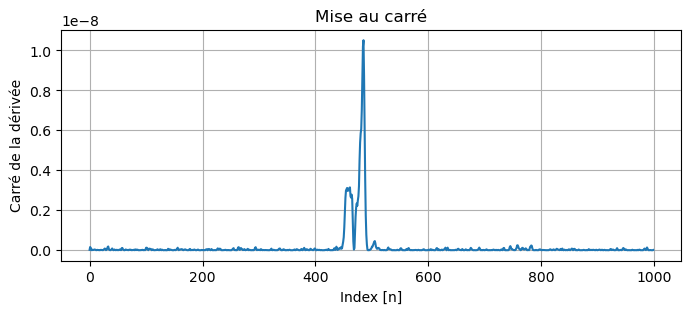

In [11]:
quadrature = [i**2 for i in derive]

#Affichage
plt.figure(figsize=(8,3))
plt.plot(quadrature)
plt.xlabel(xlabel)
plt.ylabel("Carré de la dérivée")
plt.title("Mise au carré")
plt.grid()

# Intégration et filtrage à moyenne glissante

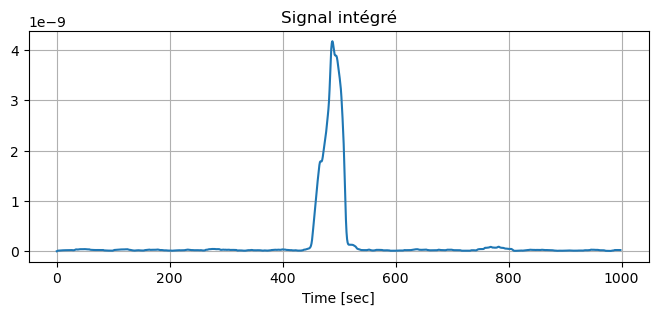

In [12]:
#Paramétrage de la taille de la fenêtre
Nw=25

filtreIntegre=[]
for N in range(0,n-1):
  filtreIntegre.append(0)
  for i in range(Nw+1):
    if(N-Nw+i>=0):
      filtreIntegre[N]+=1/Nw*(quadrature[N-Nw+i])

#Affichage
plt.figure(figsize=(8,3))
plt.plot(filtreIntegre)
plt.xlabel('Time [sec]')
plt.title('Signal intégré')
plt.grid()

# Détection des complexes QRS

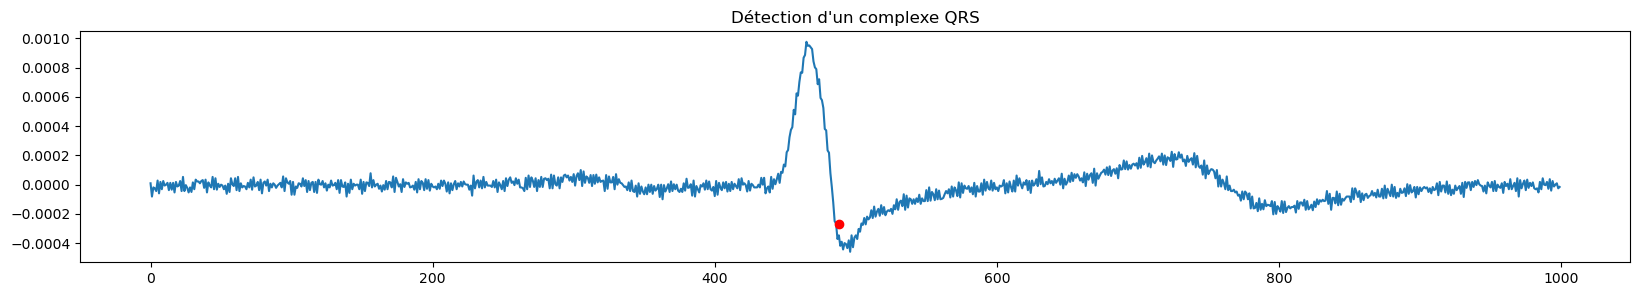

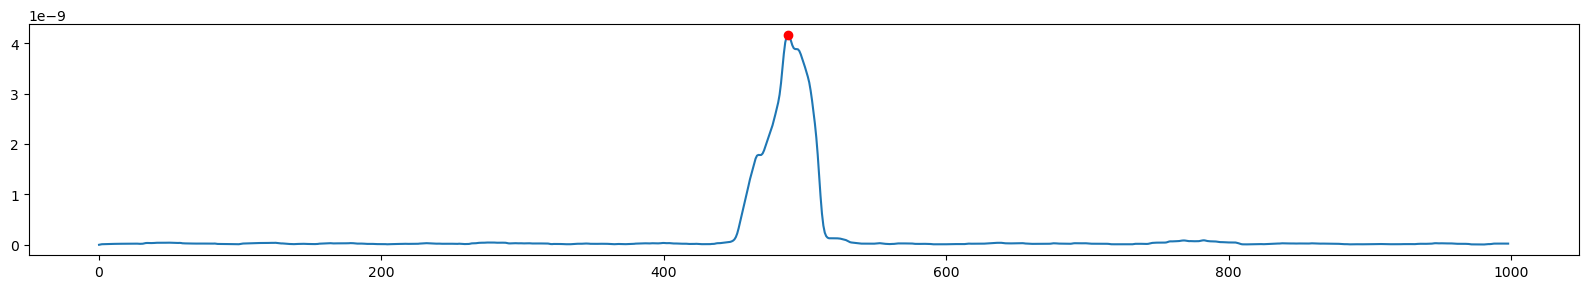

In [13]:
#Nombre de points minimum entre deux 2 phases QRS (à justifier)
minTaileQRS=500

#Création d'une succession de tableau contenant chacun un pic.
#Le pic sera dans un interval de la forme première valeur
#au dessus du seuil et dernière valeur au dessus du seuil. 

#A justifier
seuil = 2e-9

#Interval de recherche d'un pic
debutIntervalPic=0
finIntervalPic=0

#Nombre de pic détecté
compteur=0
intervalQRS = [[]]

for i in filtreIntegre:
  if(i>seuil and debutIntervalPic==0):
    debutIntervalPic=filtreIntegre.index(i)
  elif(i<seuil and debutIntervalPic>0):
    finIntervalPic=filtreIntegre.index(i)
    intervalQRS[compteur].append(debutIntervalPic)
    intervalQRS[compteur].append(finIntervalPic)
    debutIntervalPic=0
    finIntervalPic=0
    compteur+=1
    intervalQRS.append([])

#Recherche des pics sur les intervals précédents
trouverPic=[]
for i in range(len(intervalQRS)):
  if len(intervalQRS[i])==2:
    trouverPic.append(filtreIntegre.index(max(filtreIntegre[intervalQRS[i][0]:intervalQRS[i][1]])))

#Affichage des pics trouvés
plt.figure(figsize=(20,3))
plt.plot(data)
plt.title("Détection d'un complexe QRS")
for i in trouverPic:
  plt.plot(i,y[i], marker="o", color="red")
plt.figure(figsize=(20,3))
plt.plot(filtreIntegre)
for i in trouverPic:
  plt.plot(i,filtreIntegre[i], marker="o", color="red")

< [Introduction](01_Introduction.ipynb) | [Index](Index.ipynb) | [RMSSD](03_RMSSD.ipynb) >